<a href="https://colab.research.google.com/github/sarmi2325/Supervised_Learning/blob/main/churn_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/telco-customer-churn


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(f"{path}/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# Basic Cleanup
df = df.copy()
df = df.replace(" ", np.nan)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

In [ ]:
# Encode binary categorical features
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Encode target
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

In [ ]:
# Tenure group
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 72], labels=['0-12','13-24','25-48','49-72'])

# Charges ratio
df['charges_ratio'] = df['MonthlyCharges'] / (df['TotalCharges'] + 1)


# Long contract indicator
df['is_long_contract'] = df['Contract'].apply(lambda x: 1 if 'Two year' in x else 0)

# Support services available
df['has_support_services'] = ((df['OnlineSecurity'] == 'Yes') | (df['TechSupport'] == 'Yes')).astype(int)

# Multiple services
df['is_multiple_services'] = ((df['InternetService'] != 'No') & (df['PhoneService'] == 1)).astype(int)

# Encode categorical columns (label or one-hot as preferred)
df = pd.get_dummies(df, columns=['Contract', 'PaymentMethod', 'InternetService', 'tenure_group'], drop_first=True)

df['total_services'] = df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']].apply(lambda row: sum(row == 'Yes'), axis=1)

df['charge_per_months'] = df['TotalCharges'] / (df['tenure'] + 1)

df['is_streaming_heavy'] = ((df['StreamingTV'] == 'Yes') & (df['StreamingMovies'] == 'Yes')).astype(int)




In [ ]:
X = df.drop(['Churn', 'customerID'], axis=1)
X = pd.get_dummies(X, drop_first=True)

y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_sm_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Base learners
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.1, subsample=0.8,
                          colsample_bytree=0.8, scale_pos_weight=2, random_state=42, use_label_encoder=False, eval_metric='logloss')),
]

# Meta learner
meta_model = LogisticRegression(max_iter=1000)

# Stacking model
stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=True  # allows meta-learner to also use original features
)

# Train
stack_model.fit(X_train_sm_scaled, y_train_sm)
# Predict
y_pred_stack = stack_model.predict(X_test_scaled)
y_probs_stack = stack_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, y_pred_stack))
print("AUC Score:", roc_auc_score(y_test, y_probs_stack))


              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1549
           1       0.58      0.65      0.61       561

    accuracy                           0.78      2110
   macro avg       0.72      0.74      0.73      2110
weighted avg       0.79      0.78      0.78      2110

AUC Score: 0.825307915290067


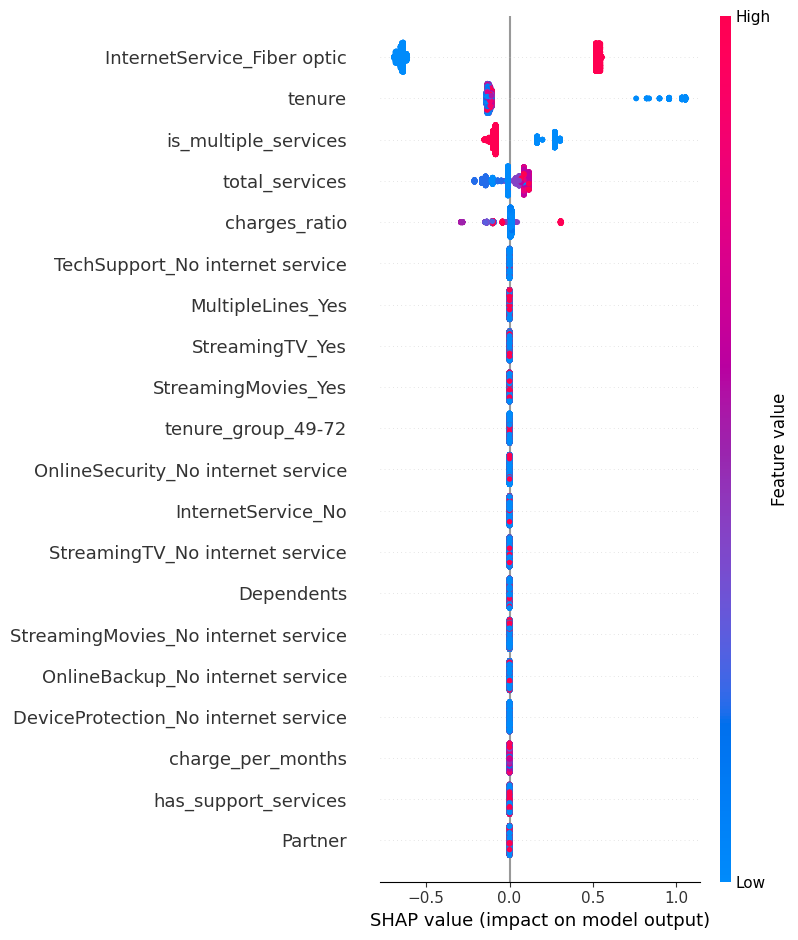

In [ ]:
import shap
# Extract XGBoost from stacking classifier
xgb_model = stack_model.named_estimators_['xgb']


# Explainer for your trained base model (XGBoost)
explainer = shap.Explainer(xgb_model, X_train_sm)
shap_values = explainer(X_test)

# Global feature importance
shap.summary_plot(shap_values, X_test)


PermutationExplainer explainer: 2111it [24:40,  1.42it/s]


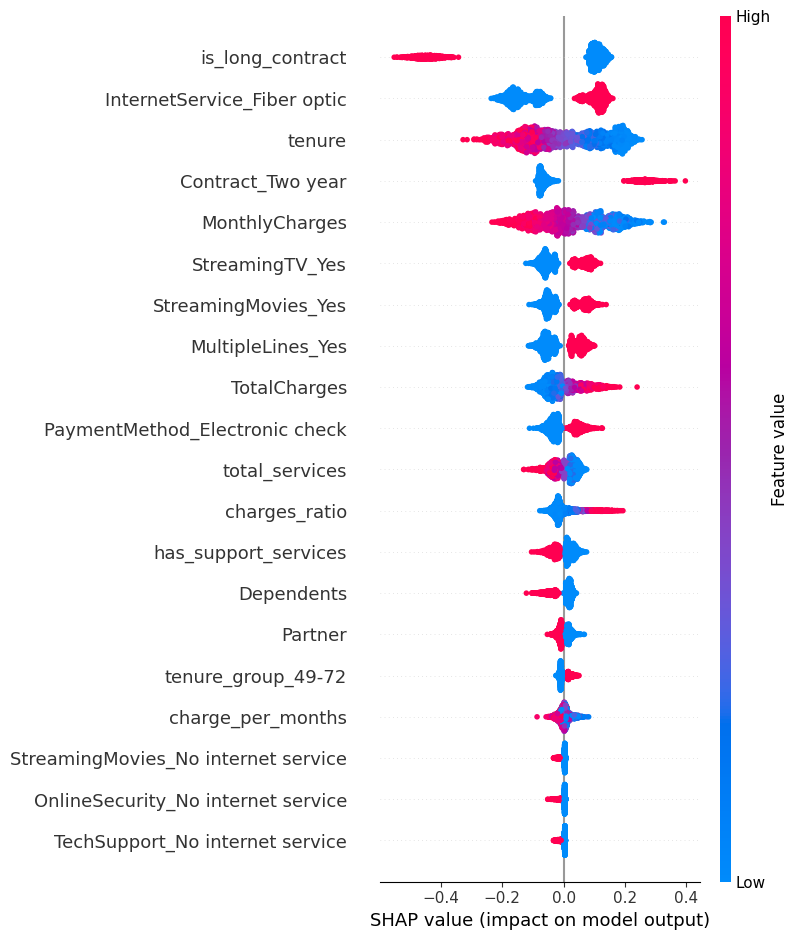

In [ ]:
import shap
import numpy as np

# Create a wrapper function for the stacking model
def predict_proba_wrapper(X):
    # The stacking model expects scaled data
    return stack_model.predict_proba(X)

# Use the wrapper function with SHAP explainer
# The masker is set to 'linear' for efficiency with linear models like the meta-learner
explainer = shap.Explainer(predict_proba_wrapper, X_test_scaled, feature_names=X_test.columns.tolist())

# Calculate SHAP values
shap_values = explainer(X_test_scaled)

# For classification, SHAP values are typically for the positive class (index 1)
# shap_values is a list of Explanation objects, one for each output.
# We need the SHAP values for the prediction of the positive class (index 1).
# The shape of shap_values.values should be (n_samples, n_features, n_outputs).
# We take the values corresponding to the positive class.
shap_values_positive = shap_values[:, :, 1]


# Global feature importance
# Use the original feature names for the plot if available
# The shap_values_positive is a shap.Explanation object for the positive class
shap.summary_plot(shap_values_positive, X_test_scaled, feature_names=X_test.columns.tolist())